In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from matplotlib import pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
def cv2_imshow(image):
    plt.imshow(image)
    plt.show()

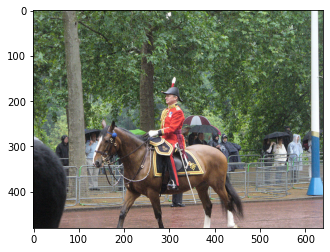

In [4]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O temp.jpg
im = cv2.imread("./temp.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
cv2_imshow(im)

In [5]:
cfg = get_cfg()

In [6]:
with open("./detectron_config.yaml", 'w') as out_file:
    out_file.write(cfg.dump())

In [8]:

from detectron2.structures import BoxMode
from os.path import join
import yaml
from typing import List
from detectron2.data import DatasetCatalog


def detectron_mnit_aug_dataset(dataset_path: str):
    def _data_fn() -> List[dict]:
        """
        annotations are of the format:
        {
            <image_file_name>: {
                image_id: int
                height: int
                width: int
                annotations: [
                    {
                        'class': int,
                        'x1': int,
                        'y1': int,
                        'x2': int,
                        'y2': int,
                        'cx': float,
                        'cy': float,
                        'height': int,
                        'width': int,
                    }
                ]
            }
        }
        We gotta convert this into format:
        [
            {
                file_name: str: the full path to the image file.
                height: int
                width: int
                image_id: str or int: unique value for each image
                annotations: List[Dict] of the format:
                {
                    bbox: List[float]: 4 numbers of bbox
                    bbox_mode: structures.BoxMode: BoxMode.XYWH_ABS or BoxMode.XYXY_ABS
                    category_id: int: number of classes, 10. (class 10 is background)
                }
            }
        ]
        """
        with open(join(dataset_path, 'annotations.yaml'), 'r') as yaml_file:
            data = yaml.safe_load(yaml_file)
        out = []
        for file_name, meta in data.items():
            annotations = [{
                'bbox': [
                    a['y1'],
                    a['x1'],
                    a['width'],
                    a['height'],
                ],
                'bbox_mode': BoxMode.XYWH_ABS,
                'category_id': a['class'],
            } for a in meta['annotations']]
            out.append({
                'file_name': join(dataset_path, file_name),
                'height': meta['height'],
                'width': meta['width'],
                'image_id': meta['image_id'],
                'annotations': annotations,
            })
        return out
    return _data_fn


dataset_path = '/Users/akhil/code/vision_lab/data/mnist_detection/sample/train'
# DatasetCatalog.remove('mnist_aug_train')
DatasetCatalog.register("mnist_aug_train", detectron_mnit_aug_dataset(dataset_path))

In [9]:
data: List[dict] = DatasetCatalog.get("mnist_aug_train")

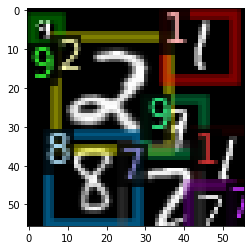

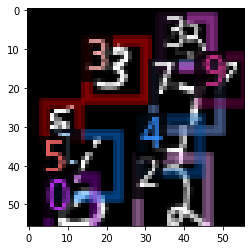

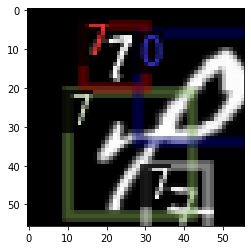

In [10]:
for d in random.sample(data, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [14]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("mnist_aug_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 3    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

cfg.MODEL.DEVICE = 'cpu'
cfg.MODEL.MASK_ON = False

In [15]:
print(cfg.dump())

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST: []
  TRAIN:
  - mnist_aug_train
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbon

In [16]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/02 16:05:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (11, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (11,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (40, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (40,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias

[11/02 16:05:49 d2.engine.train_loop]: Starting training from iteration 0
[11/02 16:06:17 d2.utils.events]:  eta: 0:00:00  iter: 2  total_loss: 3.822  loss_cls: 2.595  loss_box_reg: 0.9396  loss_rpn_cls: 0.2823  loss_rpn_loc: 0.07944  time: 5.4002  data_time: 0.7294  lr: 0.00016675  
[11/02 16:06:17 d2.engine.hooks]: Overall training speed: 1 iterations in 0:00:05 (5.4003 s / it)
[11/02 16:06:17 d2.engine.hooks]: Total training time: 0:00:05 (0:00:00 on hooks)
